1) Refazer os exemplos do último trabalho usando outras funções de ativação (tanh e ReLU) ... e pensar a respeito: nesse problema, qual foi a melhor? ... como se pode saber qual é mais eficiente? quantidade de épocas necessárias para aprender? tempo de execução?... 

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline

In [84]:
# função para traçar reta no plano cartesiano (x2 = f(x1))
def coord(w0,w1,w2,x1):
  if w2 != 0:
    return (-w0-w1*x1)/w2
  else:
    return 2000 # Inf

In [85]:
# dataset Iris
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

# setosa e versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# pegamos apenas os atributos
# comprimenento da sépala [0] e da pétala[2]

X = df.iloc[0:100, [0,2]].values

In [86]:
# base
# classe Neuronio e aprendizado estocastico/online

class Neuronio(object):

    def __init__(self, eta=0.1, epocas=50, fativ='perceptron',showErro=False):
        self.eta = eta
        self.epocas = epocas
        self.w_ = np.random.rand(1 + X.shape[1]) - 0.5
        self.fativ = fativ
        self.showErro = showErro
        self.erro_ep = 0
        self.SqError_ = []

    def somat(self, X):
        return self.w_[0] + np.dot(X, self.w_[1:])

    def sinal(self, x):
        return np.where(x >= 0.0, 1, -1)

    def tanh(self, x):
      return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

    def d_tanh(self, x):
      return 1 - self.tanh(x) * self.tanh(x)

    def ReLU(self, x):
      return np.where(x > 0.0, x, 0.1*x)  #max(0, x) .... float

    def d_ReLU(self, x):
      return np.where(x > 0.0, 1, 0.1)

    def predict(self,X):
      if self.fativ == 'sinal' or self.fativ == 'perceptron':
#        print(f"sinalPredict={self.sinal(self.somat(X))}")  # debug
        return self.sinal(self.somat(X))
      elif self.fativ == 'linear':
        return self.somat(X)
      elif self.fativ == 'tanh':
        return self.tanh(self.somat(X))
      elif self.fativ == 'ReLU':
        return self.ReLU(self.somat(X))
      else:
        return 11

    def deltaW(self, erro):
      if self.fativ == 'sinal' or self.fativ == 'perceptron':
        atualiza = self.eta * erro
      elif self.fativ == 'linear':
        atualiza = self.eta * erro
      elif self.fativ == 'tanh':
#        print(f"> eta={self.eta} tanh={self.tanh(erro)} dtanh={self.d_tanh(erro)} erro={erro}")
        atualiza = self.eta * self.d_tanh(erro) * erro
      elif self.fativ == 'ReLU':
        atualiza = self.eta * self.d_ReLU(erro) * erro
      else:
        print(f"Função de ativação '{self.fativ}' desconhecida")
        exit()
      return atualiza

    def treinaGD(self,X,y):
      self.SqError_ = []
      self.erros_classif_ = []
      for ep in range(self.epocas):
        erro_classif = 0
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        Xs = X[indices]
        ys = y[indices]
        outputs = self.predict(Xs)
        erros = (ys - outputs)
       # print(outputs,erros)
        erro_classif = np.where(ys*outputs < 0, 1, 0).sum()
        self.erros_classif_.append(erro_classif)
        self.w_[1:] += self.eta * Xs.T.dot(erros)
        self.w_[0] += self.eta * erros.sum()
        SqError = (erros**2).sum() / 2.0 # ou np.square(erros)/2
        self.SqError_.append(SqError)
        if self.showErro:
          if ep == 0:
            print(f"{'Época':^10}\tErro")
          else:
            print(f"{str(ep):^10}\t{erro_classif}")
      return self

    def treinaSGD(self, X, y):
        self.erros_ = []
        self.erros_classif_ = []
        self.SqError_ = []
        for ep in range(self.epocas):
            erro_ep = 0
            erro_classif = 0
            SqError = 0

            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            Xs = X[indices]
            ys = y[indices]

            for xi, target in zip(Xs, ys):
              output = self.predict(xi)
              erro = target - output
              SqError += erro*erro
              erro_ep += erro
              if (float(target)*float(output)) < 0:
                #print(f"ep={ep} {xi} target={target} output={output} t*o={target*output}") # debug
                erro_classif += 1

              atualizacao = self.deltaW(erro)
              self.w_[0] +=  atualizacao * 1
              self.w_[1:] +=  atualizacao * xi

            self.erros_.append(erro_ep)
            self.SqError_.append(SqError)
            self.erros_classif_.append(erro_classif)
            if self.showErro:
              if ep == 0:
                print(f"{'Época':^10}\tErro")
              else:
                print(f"{str(ep):^10}\t{erro_classif}")

        return self

In [87]:
# separando datasets de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=102)

In [88]:
# cria objeto

np.random.seed(35)  # deixar reproduzível

# classifier2 = Neuronio(fativ='tanh', eta=0.00002, epocas=1000,showErro=False)
classifier2 = Neuronio(fativ='tanh', eta=0.00002, epocas=250,showErro=True)

W0 = classifier2.w_.copy()

In [89]:
# treinamento
%time classifier2.treinaGD(X_train,y_train)

  Época   	Erro
    1     	39
    2     	39
    3     	39
    4     	39
    5     	39
    6     	39
    7     	39
    8     	39
    9     	39
    10    	39
    11    	39
    12    	39
    13    	39
    14    	39
    15    	39
    16    	39
    17    	39
    18    	39
    19    	39
    20    	39
    21    	39
    22    	39
    23    	39
    24    	39
    25    	39
    26    	39
    27    	39
    28    	39
    29    	39
    30    	39
    31    	39
    32    	39
    33    	39
    34    	39
    35    	39
    36    	39
    37    	40
    38    	44
    39    	49
    40    	66
    41    	79
    42    	79
    43    	80
    44    	80
    45    	80
    46    	80
    47    	80
    48    	80
    49    	80
    50    	79
    51    	76
    52    	65
    53    	55
    54    	46
    55    	42
    56    	41
    57    	41
    58    	41
    59    	41
    60    	41
    61    	41
    62    	41
    63    	41
    64    	41
    65    	41
    66    	41
    67    	41
    68    	41
    69    	41
    70    	41
    

In [90]:
# calcula previsões - e compara com target
preds = classifier2.predict(X_test)
PercClassifica = 100 * np.where(preds*y_test < 0, 0, 1).sum() / len(y_test)
PercClassifica

100.0

In [91]:
categ_preds = np.where(preds < 0, -1, 1)
cm = confusion_matrix(y_test, categ_preds)
print(cm)
accuracy_score(y_test,categ_preds)

[[ 9  0]
 [ 0 11]]


1.0

Text(0, 0.5, 'Erros de classificação por época')

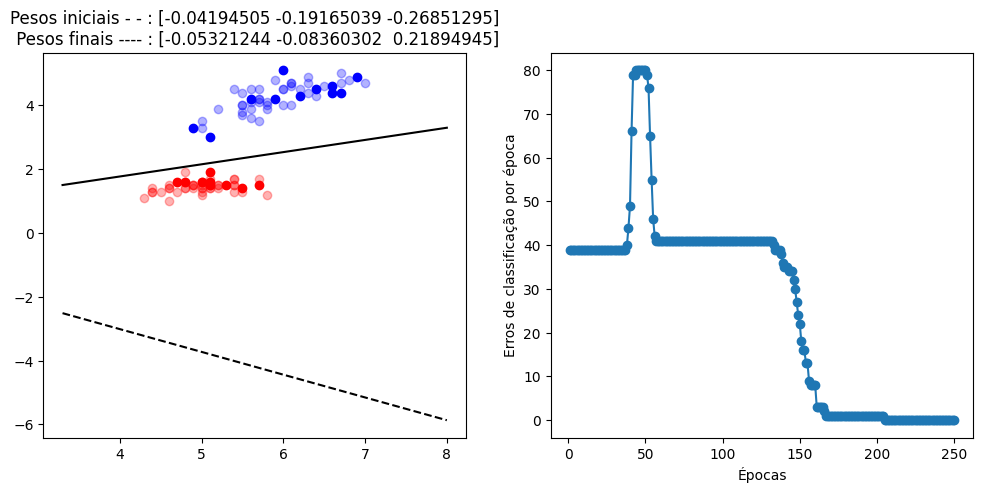

In [92]:
# base
rna = classifier2
xr1, yr1 = X_train[y_train==1,0],X_train[y_train==1,1]
xr0, yr0 = X_train[y_train==-1,0], X_train[y_train==-1,1]

xs1, ys1 = X_test[y_test==1,0],X_test[y_test==1,1]
xs0, ys0 = X_test[y_test==-1,0], X_test[y_test==-1,1]

ylim = [min(min(xr1), min(xs1) , min(xr0),min(xs0))-1, max(max(xr0),max(xs0) , max(xr1),max(xs1))+1]
x = np.linspace(ylim[0], ylim[1], 2)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 5))

# mostra o classificador antes e depois do treinamento
titulo = f'Pesos iniciais - - : {W0}\n Pesos finais ---- : {rna.w_}'
ax1.set_title(titulo)
ax1.ylim = [min(min(xr1) , min(xr0))-1, max(max(xr0) , max(xr1))+1]
ax1.scatter(xr1,yr1, color='blue',alpha=0.3)
ax1.scatter(xr0,yr0,color='red',alpha=0.3)
ax1.scatter(xs1,ys1, color='blue')
ax1.scatter(xs0,ys0,color='red')
ax1.plot(ylim,coord(W0[0],W0[1],W0[2], x),color='black',linestyle='dashed')
ax1.plot(ylim,coord(rna.w_[0],rna.w_[1],rna.w_[2], x),color='black')

ax2.plot(range(1, len(rna.erros_classif_)+1), rna.erros_classif_, marker='o')
#ax2.plot(range(1, len(rna.SqErrors_)+1), rna.SqError_, marker='o')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Erros de classificação por época')

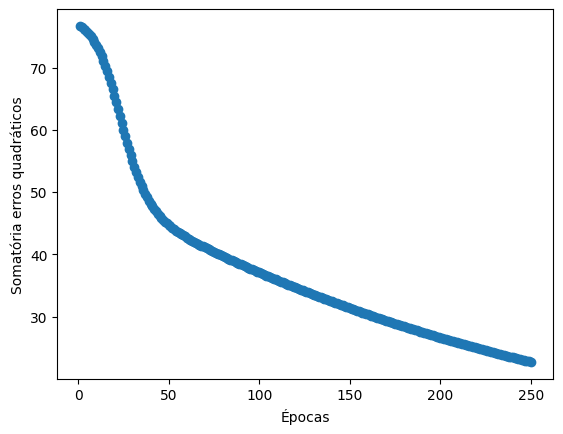

In [93]:
# evolução do custo
plt.plot(range(1, len(rna.SqError_)+1), rna.SqError_, marker='o')
plt.xlabel('Épocas')
plt.ylabel('Somatória erros quadráticos')
plt.show()